In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

#TODO: change to relative file path
file_path = r"C:\Users\jmpur\Downloads\Louisville_Metro_KY_-_Animal_Service_Intake_and_Outcome.csv"

old_df = pd.read_csv(file_path)

df = old_df.dropna()

df

,kennel,animalid,jurisdiction,intype,insubtype,indate,surreason,outtype,outsubtype,outdate,animaltype,sex,bites,petsize,color,breed,sourcezipcode,ObjectId
0,605,A492190,40243,STRAY,FIELD,2021/09/02 00:00:00,STRAY,ADOPTION,REFERRAL,2021/09/07 00:00:00,DOG,N,N,LARGE,BL BRINDLE,PIT BULL / MIX,40218,1
1,INTAKE,A497115,40215,OWNER SUR,EUTH REQ,2019/01/11 00:00:00,EUTH MED,EUTH,REQUESTED,2019/01/11 00:00:00,DOG,M,N,PUPPY,BLACK / RED,DOBERMAN PINSCH,40215,2
2,INTAKE,A307550,40291,STRAY,OTC,2020/01/10 00:00:00,STRAY,RTO,IN KENNEL,2020/01/10 00:00:00,DOG,N,N,MED,BROWN,BASSET HOUND / BASSET HOUND,40291,3
3,ACO UNIT,A331757,40222,CONFISCATE,OWNER DIED,2020/09/21 00:00:00,OWNER DIED,EUTH,INHUMANE,2020/09/21 00:00:00,DOG,N,N,LARGE,YELLOW,LABRADOR RETR,40243,4
4,902,A571544,40216,STRAY,OTC,2022/11/14 00:00:00,STRAY,RTO,IN KENNEL,2022/11/19 00:00:00,DOG,M,N,LARGE,GOLD,GOLDEN RETR,40216,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54481,K109,A677601,40202,STRAY,FIELD,2020/02/22 00:00:00,STRAY,RTO,IN KENNEL,2020/02/22 00:00:00,DOG,S,N,SMALL,TAN / WHITE,CHIHUAHUA LH,40218,54482
54484,404,A677801,40210,OWNER SUR,EUTH REQ,2020/02/27 00:00:00,AGG ANIMAL,TRANSPORT,RESCUE GRP,2020/03/04 00:00:00,DOG,S,N,LARGE,BROWN,BOXER / GERM SHEPHERD,40210,54485
54485,N16,A677998,40208,STRAY,OTC,2020/03/04 00:00:00,STRAY,TRANSFER,KHS,2020/03/12 00:00:00,DOG,N,N,LARGE,BR BRINDLE,DUTCH SHEPHERD / MIX,40214,54486
54490,N17,A735508,40219,STRAY,OTC,2023/03/31 00:00:00,STRAY,FOSTER,TIME/SPACE,2023/04/15 00:00:00,DOG,N,N,LARGE,BROWN / BLACK,BELG MALINOIS / ALASKAN HUSKY,40219,54491


In [25]:
df.insert(6, 'indate year', pd.to_datetime(df['indate']).dt.year)
df.insert(11, 'outdate year', pd.to_datetime(df['outdate']).dt.year)

df

# ~~Unused~~
# df['indate year'] = pd.to_datetime(df['indate']).dt.year
# move_column = df.pop('indate year')
# df.insert(6, 'indate year', move_column)

,kennel,animalid,jurisdiction,intype,insubtype,indate,indate year,surreason,outtype,outsubtype,outdate,outdate year,animaltype,sex,bites,petsize,color,breed,sourcezipcode,ObjectId
0,605,A492190,40243,STRAY,FIELD,2021/09/02 00:00:00,2021,STRAY,ADOPTION,REFERRAL,2021/09/07 00:00:00,2021,DOG,N,N,LARGE,BL BRINDLE,PIT BULL / MIX,40218,1
1,INTAKE,A497115,40215,OWNER SUR,EUTH REQ,2019/01/11 00:00:00,2019,EUTH MED,EUTH,REQUESTED,2019/01/11 00:00:00,2019,DOG,M,N,PUPPY,BLACK / RED,DOBERMAN PINSCH,40215,2
2,INTAKE,A307550,40291,STRAY,OTC,2020/01/10 00:00:00,2020,STRAY,RTO,IN KENNEL,2020/01/10 00:00:00,2020,DOG,N,N,MED,BROWN,BASSET HOUND / BASSET HOUND,40291,3
3,ACO UNIT,A331757,40222,CONFISCATE,OWNER DIED,2020/09/21 00:00:00,2020,OWNER DIED,EUTH,INHUMANE,2020/09/21 00:00:00,2020,DOG,N,N,LARGE,YELLOW,LABRADOR RETR,40243,4
4,902,A571544,40216,STRAY,OTC,2022/11/14 00:00:00,2022,STRAY,RTO,IN KENNEL,2022/11/19 00:00:00,2022,DOG,M,N,LARGE,GOLD,GOLDEN RETR,40216,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54481,K109,A677601,40202,STRAY,FIELD,2020/02/22 00:00:00,2020,STRAY,RTO,IN KENNEL,2020/02/22 00:00:00,2020,DOG,S,N,SMALL,TAN / WHITE,CHIHUAHUA LH,40218,54482
54484,404,A677801,40210,OWNER SUR,EUTH REQ,2020/02/27 00:00:00,2020,AGG ANIMAL,TRANSPORT,RESCUE GRP,2020/03/04 00:00:00,2020,DOG,S,N,LARGE,BROWN,BOXER / GERM SHEPHERD,40210,54485
54485,N16,A677998,40208,STRAY,OTC,2020/03/04 00:00:00,2020,STRAY,TRANSFER,KHS,2020/03/12 00:00:00,2020,DOG,N,N,LARGE,BR BRINDLE,DUTCH SHEPHERD / MIX,40214,54486
54490,N17,A735508,40219,STRAY,OTC,2023/03/31 00:00:00,2023,STRAY,FOSTER,TIME/SPACE,2023/04/15 00:00:00,2023,DOG,N,N,LARGE,BROWN / BLACK,BELG MALINOIS / ALASKAN HUSKY,40219,54491


In [26]:
#remove time from dates
# '.loc :' is used for avoiding SettingWithCopyWarning
df.loc[:, 'indate'] = pd.to_datetime(df['indate']).dt.date
df.loc[:, 'outdate'] = pd.to_datetime(df['outdate']).dt.date

df

,kennel,animalid,jurisdiction,intype,insubtype,indate,indate year,surreason,outtype,outsubtype,outdate,outdate year,animaltype,sex,bites,petsize,color,breed,sourcezipcode,ObjectId
0,605,A492190,40243,STRAY,FIELD,2021-09-02,2021,STRAY,ADOPTION,REFERRAL,2021-09-07,2021,DOG,N,N,LARGE,BL BRINDLE,PIT BULL / MIX,40218,1
1,INTAKE,A497115,40215,OWNER SUR,EUTH REQ,2019-01-11,2019,EUTH MED,EUTH,REQUESTED,2019-01-11,2019,DOG,M,N,PUPPY,BLACK / RED,DOBERMAN PINSCH,40215,2
2,INTAKE,A307550,40291,STRAY,OTC,2020-01-10,2020,STRAY,RTO,IN KENNEL,2020-01-10,2020,DOG,N,N,MED,BROWN,BASSET HOUND / BASSET HOUND,40291,3
3,ACO UNIT,A331757,40222,CONFISCATE,OWNER DIED,2020-09-21,2020,OWNER DIED,EUTH,INHUMANE,2020-09-21,2020,DOG,N,N,LARGE,YELLOW,LABRADOR RETR,40243,4
4,902,A571544,40216,STRAY,OTC,2022-11-14,2022,STRAY,RTO,IN KENNEL,2022-11-19,2022,DOG,M,N,LARGE,GOLD,GOLDEN RETR,40216,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54481,K109,A677601,40202,STRAY,FIELD,2020-02-22,2020,STRAY,RTO,IN KENNEL,2020-02-22,2020,DOG,S,N,SMALL,TAN / WHITE,CHIHUAHUA LH,40218,54482
54484,404,A677801,40210,OWNER SUR,EUTH REQ,2020-02-27,2020,AGG ANIMAL,TRANSPORT,RESCUE GRP,2020-03-04,2020,DOG,S,N,LARGE,BROWN,BOXER / GERM SHEPHERD,40210,54485
54485,N16,A677998,40208,STRAY,OTC,2020-03-04,2020,STRAY,TRANSFER,KHS,2020-03-12,2020,DOG,N,N,LARGE,BR BRINDLE,DUTCH SHEPHERD / MIX,40214,54486
54490,N17,A735508,40219,STRAY,OTC,2023-03-31,2023,STRAY,FOSTER,TIME/SPACE,2023-04-15,2023,DOG,N,N,LARGE,BROWN / BLACK,BELG MALINOIS / ALASKAN HUSKY,40219,54491


In [27]:
#How many total animals are in this study?
print("Total animals:", df.animalid.nunique())

Total animals: 25346


In [28]:
#How many of EACH animal is in the study?
print(df.value_counts('animaltype').head(), df.value_counts('breed').head())

animaltype
DOG       19228
CAT       12946
OTHER       292
RABBIT      264
BIRD         75
Name: count, dtype: int64 breed
DOMESTIC SH            10847
PIT BULL                3816
DOMESTIC MH             1191
PIT BULL / MIX          1062
LABRADOR RETR / MIX      960
Name: count, dtype: int64


In [29]:
print(df.intype.value_counts(), df.outtype.value_counts())
#, df.insubtype.value_counts()

intype
STRAY         22265
FOSTER         5944
OWNER SUR      2051
RETURN         1085
CONFISCATE      865
DISPOSAL        660
FOR TRANSP       21
Name: count, dtype: int64 outtype
ADOPTION     12369
FOSTER        5348
RTO           5212
TRANSFER      3737
EUTH          2811
TNR           1647
DISPOSAL       881
TRANSPORT      481
DIED           382
LOST            21
RELEASE          2
Name: count, dtype: int64


In [30]:
# conn = sqlite3.connect('animal_data.db')
# cur = conn.cursor()

# df.to_sql('table1', conn, if_exists='replace', index=False)

# test1 = pd.read_sql_query("SELECT * FROM table1 WHERE intype='STRAY'", conn)
# print(test1)

# conn.close()


   year  count
1  2019   7317
4  2020   5452
2  2021   6718
0  2022   7605
3  2023   5799


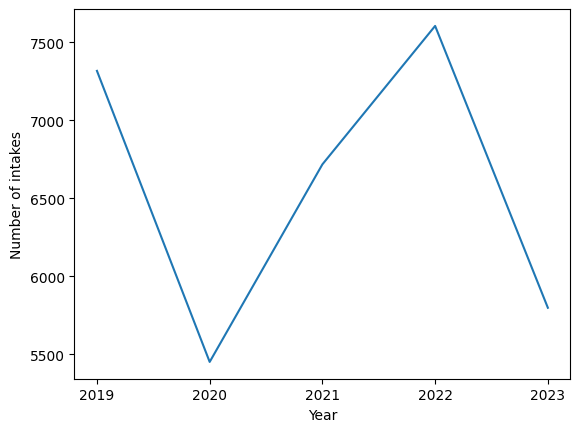

In [31]:
#line graph
#number of intakes over the years
#print(df.value_counts('indate year'), df.value_counts('outdate year'))
indate_df = df.value_counts('indate year').reset_index().sort_values(['indate year'])
indate_df.columns = ['year', 'count']

print(indate_df)

#change X axis to only show integers
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(indate_df['year'], indate_df['count'])
plt.xlabel('Year')
plt.ylabel('Number of intakes')
plt.show()

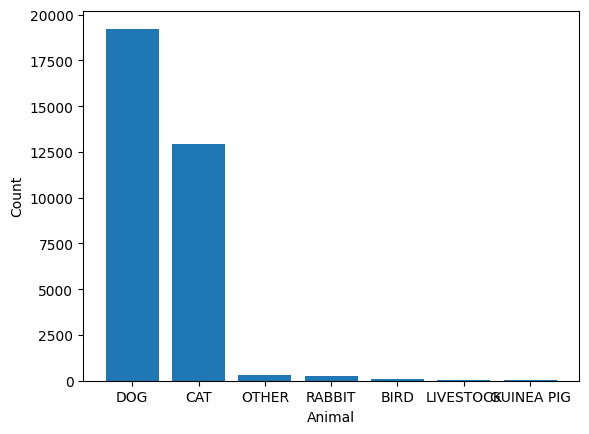

In [32]:
animal_count_df = df.value_counts('animaltype').reset_index()
animal_count_df.columns = ['animal', 'count']
animal_count_df.sort_values(['count'])

plt.bar(animal_count_df['animal'], animal_count_df['count'])
plt.xlabel('Animal')
plt.ylabel('Count')
plt.show()